In [1]:
import numpy as np
import netCDF4
import platform
import re
import sys
import importlib
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
import os
import glob
import rasterio
from PIL import Image

if platform.system() == 'Darwin':
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive/'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
elif platform.system() == 'Linux':
    base_FP = '/home/subin/data'
    cpuserver_data_FP = '/home/subin/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')
print(base_FP, cpuserver_data_FP)

import HydroAI.Plot as hPlot
import HydroAI.LULC as hLULC
import HydroAI.Data as hData
import HydroAI.Grid as hGrid
importlib.reload(hLULC);
importlib.reload(hPlot);
importlib.reload(hData);
importlib.reload(hGrid);

import warnings
warnings.filterwarnings("ignore")

/home/subin/data /home/subin/cpuserver_data


## 0. Read and plot MODIS raw dataset



In [2]:
FP = cpuserver_data_FP + '/MODIS/MOD13A2/' # vegetation_indices (NDVI)
FP = cpuserver_data_FP + '/MODIS/MOD11A2/' # LST

file_list =  hData.get_file_list(FP, 'hdf')
print(file_list[:5])
input_file = file_list[4]

['/home/subin/cpuserver_data/MODIS/MOD11A2/2010.01.01/MOD11A2.A2010001.h19v07.061.2021154175517.hdf', '/home/subin/cpuserver_data/MODIS/MOD11A2/2010.01.01/MOD11A2.A2010001.h19v08.061.2021154174227.hdf', '/home/subin/cpuserver_data/MODIS/MOD11A2/2010.01.01/MOD11A2.A2010001.h19v09.061.2021154174220.hdf', '/home/subin/cpuserver_data/MODIS/MOD11A2/2010.01.01/MOD11A2.A2010001.h20v07.061.2021154175727.hdf', '/home/subin/cpuserver_data/MODIS/MOD11A2/2010.01.01/MOD11A2.A2010001.h20v08.061.2021154175736.hdf']


In [44]:
hdf = SD(input_file, SDC.READ)
datasets = hdf.datasets()
for name, info in datasets.items():
    print(name)
    print(info)

LST_Day_1km
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 23, 0)
QC_Day
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 21, 1)
Day_view_time
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 21, 2)
Day_view_angl
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 21, 3)
LST_Night_1km
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 23, 4)
QC_Night
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 21, 5)
Night_view_time
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 21, 6)
Night_view_angl
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 21, 7)
Emis_31
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 21, 8)
Emis_32
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 21, 9)
Cl

Failed to read '1 km 16 days NDVI' from HDF4 file /home/subin/cpuserver_data/MODIS/lst/MOD11A2.A2010001.h20v08.061.2021154175736.hdf: select: non-existent dataset
<class 'numpy.ndarray'>
(1200, 1200)


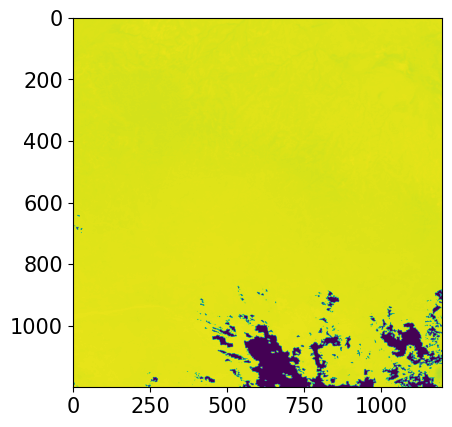

In [45]:
var = hData.read_hdf4_variable(input_file, '1 km 16 days NDVI')
var = hData.read_hdf4_variable(input_file, 'LST_Night_1km')
print(type(var))
print(np.shape(var))
plt.imshow(var)

## 1. Read merged tif image dataset (NDVI, LST) with cropping study area

In [2]:
def read_tif_images(root_folder, variable, matched_dates=[]):
    images = []; dates = []

    if matched_dates == []:
        folder_pattern = os.path.join(root_folder, '[0-9][0-9][0-9][0-9].[0-9][0-9].[0-9][0-9]')
        folders = glob.glob(folder_pattern)
        folders = sorted(folders)
    else:    
        folders = [f'{root_folder}/{md}' for md in matched_dates]

    #for fi, folder in enumerate(folders[:5]): # Light version for test code
    for fi, folder in enumerate(folders):

        merged_tif_file = glob.glob(os.path.join(folder, f'merged/*{variable}_WGS84.tif'))

        try:
            with rasterio.open(merged_tif_file[0]) as src:
                if fi == 0:
                    transform = src.transform
                    width = src.width
                    height = src.height
                    rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
                    xs, ys = rasterio.transform.xy(transform, rows, cols)
                    lons = np.array(xs)
                    lats = np.array(ys)
                    
                    # Crop study_area = {'lat':(-10, 20), 'lon':(20, 50)}
                    lon_crop = (lons > 20) & (lons < 50)
                    lat_crop = (lats > -10) & (lats < 20)
    
                    combined_crop = lat_crop & lon_crop
                    
                    # Find the bounding box of the true values in the mask
                    row_indices, col_indices = np.where(combined_crop)
                    min_row, max_row = row_indices.min(), row_indices.max()
                    min_col, max_col = col_indices.min(), col_indices.max()
                    
                    cropped_lat = lats[min_row:max_row+1, min_col:max_col+1]
                    cropped_lon = lons[min_row:max_row+1, min_col:max_col+1]
                    
                data = src.read(1).astype('float32')
                cropped_data = data[min_row:max_row+1, min_col:max_col+1]
                images.append( cropped_data )
        
        except IndexError:
            print(f'No dataset in \n {folder}')
            nan_data = np.full( ( max_row+1 - min_row , max_col+1 - min_col ), np.nan )
            images.append( nan_data )
        '''
        with Image.open(merged_tif_file[0]) as img:
            img_array = np.array(img.copy())
            images.append(img_array)
        '''
        date_pattern = r'\d{4}\.\d{2}\.\d{2}'
        match = re.search(date_pattern, folder).group(0)
        dates.append(match)

    images = np.transpose(images, (1, 2, 0)) # Transforming shape into (lat(row), lon(column), date)
    return images, cropped_lon, cropped_lat, dates

In [3]:
NDVI_images, NDVI_lon, NDVI_lat, NDVI_dates = read_tif_images(f'{cpuserver_data_FP}/MODIS/MOD13A2', 'NDVI')
print(np.shape(NDVI_images), np.shape(NDVI_dates))
plt.imshow(NDVI_images[:, :, 0])

(3648, 3648, 322) (322,)


In [4]:
NDVI_lat

array([[19.99514498, 19.99514498, 19.99514498, ..., 19.99514498,
        19.99514498, 19.99514498],
       [19.98692069, 19.98692069, 19.98692069, ..., 19.98692069,
        19.98692069, 19.98692069],
       [19.97869639, 19.97869639, 19.97869639, ..., 19.97869639,
        19.97869639, 19.97869639],
       ...,
       [-9.98241074, -9.98241074, -9.98241074, ..., -9.98241074,
        -9.98241074, -9.98241074],
       [-9.99063504, -9.99063504, -9.99063504, ..., -9.99063504,
        -9.99063504, -9.99063504],
       [-9.99885933, -9.99885933, -9.99885933, ..., -9.99885933,
        -9.99885933, -9.99885933]])

In [5]:
NDVI_lon

array([[20.00485502, 20.01307931, 20.02130361, ..., 49.98241074,
        49.99063503, 49.99885933],
       [20.00485502, 20.01307931, 20.02130361, ..., 49.98241074,
        49.99063503, 49.99885933],
       [20.00485502, 20.01307931, 20.02130361, ..., 49.98241074,
        49.99063503, 49.99885933],
       ...,
       [20.00485502, 20.01307931, 20.02130361, ..., 49.98241074,
        49.99063503, 49.99885933],
       [20.00485502, 20.01307931, 20.02130361, ..., 49.98241074,
        49.99063503, 49.99885933],
       [20.00485502, 20.01307931, 20.02130361, ..., 49.98241074,
        49.99063503, 49.99885933]])

In [6]:
# LST 8 days (twice than NDVI) -> matched_dates are needed.
LST_images, LST_lon, LST_lat, LST_dates = read_tif_images(f'{cpuserver_data_FP}/MODIS/MOD11A2', 'LST', matched_dates=NDVI_dates)
print(np.shape(LST_images), np.shape(LST_dates))
plt.imshow(LST_images[:, :, 0])

No dataset in 
 /home/subin/cpuserver_data/MODIS/MOD11A2/2022.10.16
(3660, 3661, 322) (322,)


## 2. Mask non-valid values and apply scale factors 
(ref. raw dataset nc file)

In [7]:
# valid range (-2000, 10000)
NDVI_images[(NDVI_images < -2000) & (NDVI_images > 10000)] = np.nan

# valid range (7500, -1)
LST_images[LST_images < 7500] = np.nan

In [8]:
# 1_km_16_days_NDVI
NDVI_scale_factor = 10000.0; NDVI_add_offset = 0.0
NDVI_images_scaled = NDVI_images / NDVI_scale_factor + NDVI_add_offset
#print(NDVI_images_scaled[1000:1500, 1000:1500, 0])
NDVI_images = [] # Flush memory

# LST_Day_1km 
LST_scale_factor = 0.02; LST_add_offset = 0.0
LST_images_scaled = LST_images * LST_scale_factor + LST_add_offset
#print(LST_images_scaled[1000:1500, 1000:1500, 0])
LST_images = [] # Flush memory

## 3. Apply Resampling and save resampled nc files
(for standardized grid system)

In [9]:
#study_area = {'lat':(-10, 20), 'lon':(20, 50)}

target_projection = 'eqd_001' 
domain_lon, domain_lat = hGrid.generate_lon_lat_eqdgrid(0.01)
print(np.shape(domain_lon))

lat_0 = 90
lon_0 = 180

domain_lon = domain_lon[100*(lat_0-20):100*(lat_0-(-10)), 100*(lon_0+20):100*(lon_0+50)]
domain_lat = domain_lat[100*(lat_0-20):100*(lat_0-(-10)), 100*(lon_0+20):100*(lon_0+50)]
print(np.shape(domain_lon))
print(domain_lat[:,0])
print(domain_lon[0])

(18000, 36000)
(3000, 3000)
[19.995 19.985 19.975 ... -9.975 -9.985 -9.995]
[20.005 20.015 20.025 ... 49.975 49.985 49.995]


In [10]:
m, n = np.shape(domain_lon)
NDVI_total = np.zeros((m, n, len(NDVI_dates)), dtype='float64')
LST_total  = np.zeros((m, n, len(LST_dates)),  dtype='float64')

for i, date in enumerate(NDVI_dates):
    Resampled_NDVI  = hData.Resampling(domain_lon, domain_lat, NDVI_lon, NDVI_lat, NDVI_images_scaled[:, :, i], sampling_method='nearest', mag_factor=1)
    Resampled_LST   = hData.Resampling(domain_lon, domain_lat, LST_lon,  LST_lat,  LST_images_scaled[:, :, i],  sampling_method='nearest', mag_factor=1)

    NDVI_total[:, :, i] = Resampled_NDVI
    LST_total[:, :, i]  = Resampled_LST


nc_file_name = f'{cpuserver_data_FP}/MODIS/MODIS_NDVI_LST_dates{len(NDVI_dates)}_R_eqd001.nc'
nc_file_name = '/home/subin/MODIS_NDVI_LST_R_eqd001.nc'

print(f"Saving: {nc_file_name}")
hData.create_netcdf_file(
    nc_file    = nc_file_name,
    latitude   = domain_lat,
    longitude  = domain_lon,
    NDVI  = NDVI_total,
    LST   = LST_total)

print(f"NetCDF file created: {nc_file_name}")

Saving: /home/subin/MODIS_NDVI_LST_R_eqd001.nc
NetCDF file /home/subin/MODIS_NDVI_LST_R_eqd001.nc created successfully.
NetCDF file created: /home/subin/MODIS_NDVI_LST_R_eqd001.nc


In [11]:
# Flush memories
NDVI_images_scaled = []
LST_images_scaled = []

len(NDVI_dates)

322

## 4. Read and plot resampled nc file 

In [12]:
nc_file_name = '/home/subin/MODIS_NDVI_LST_R_eqd001.nc'

nc_data  = netCDF4.Dataset(nc_file_name)
NDVI_total  = nc_data.variables['NDVI'][:].data
LST_total  = nc_data.variables['LST'][:].data
domain_lon = nc_data.variables['longitude'][:].data
domain_lat = nc_data.variables['latitude'][:].data
nc_data.close()

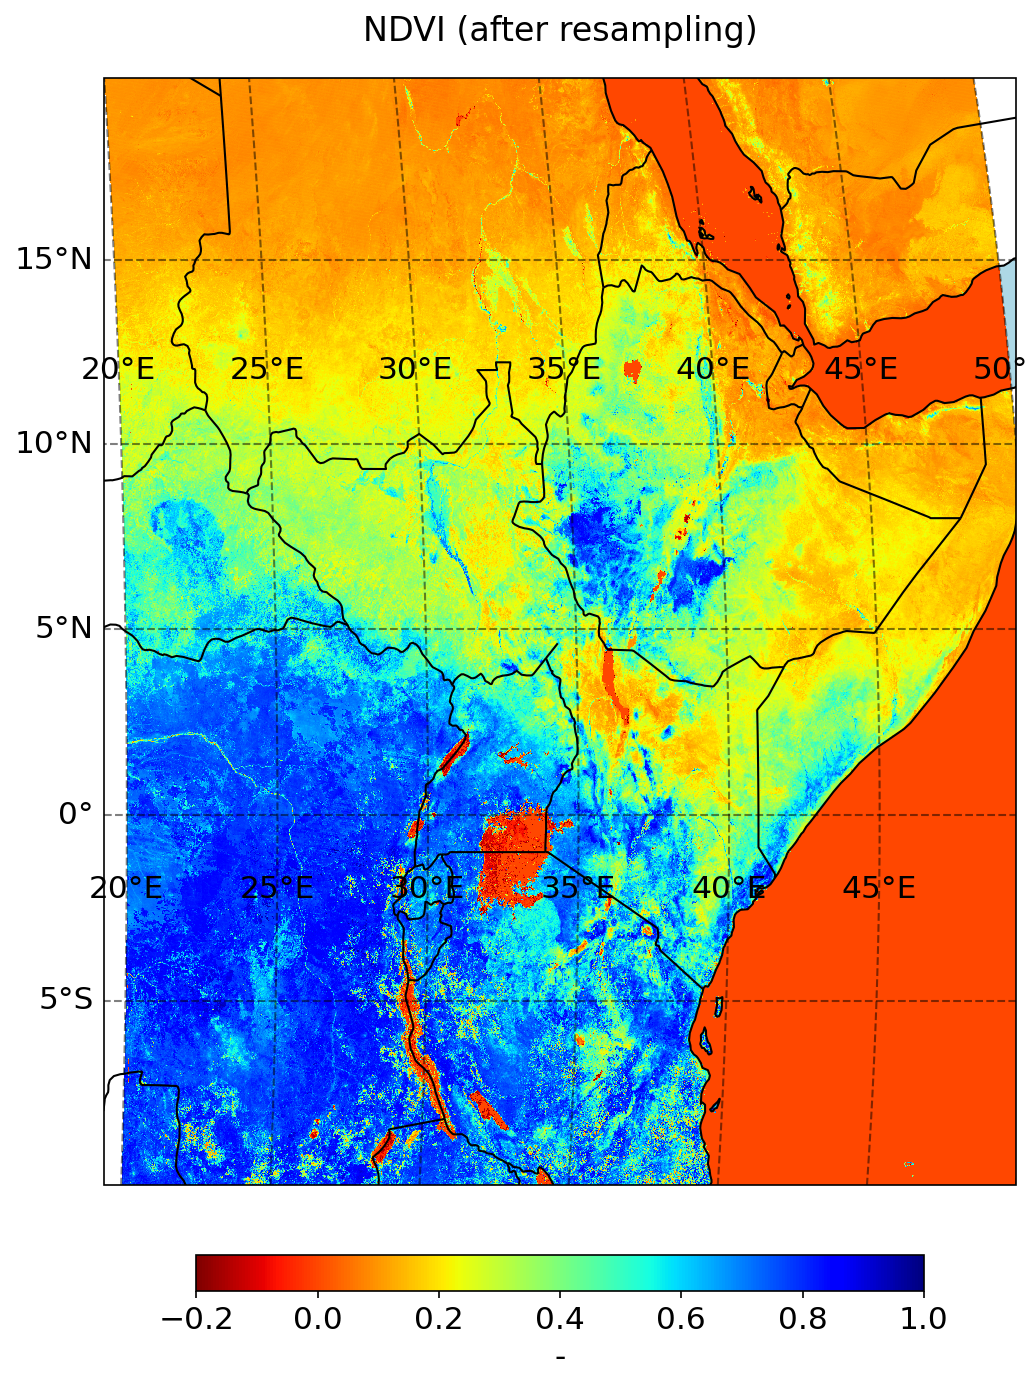

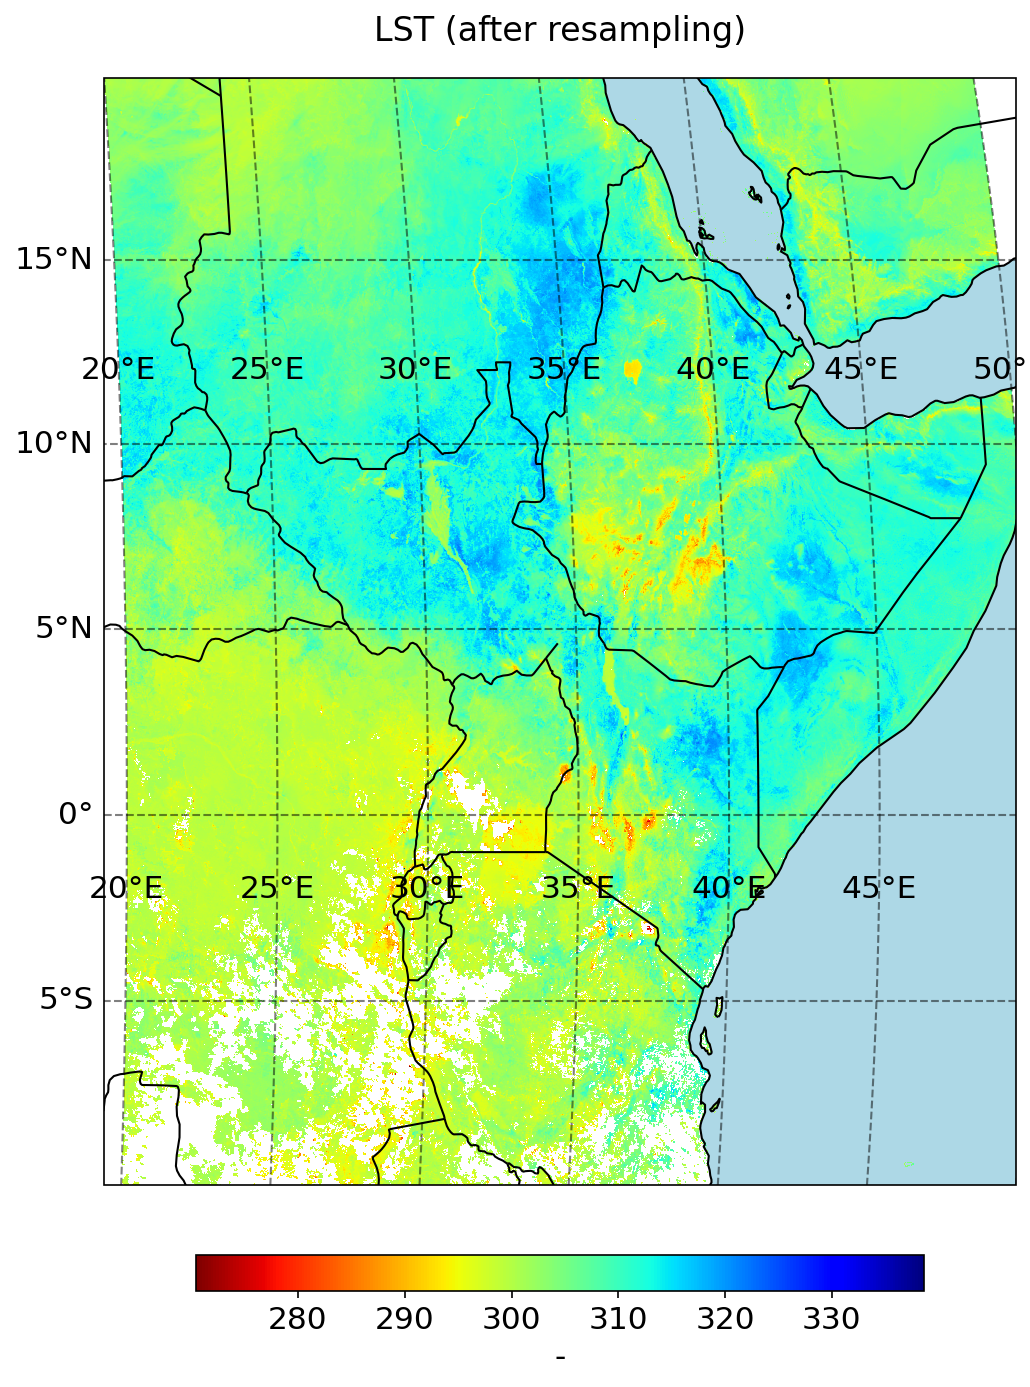

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [13]:
date_index = 0 # Maximum: len(NDVI_dates) - 1

target = NDVI_total[:,:, date_index]
hPlot.plot_map(domain_lon, domain_lat, target, np.nanmin(target), np.nanmax(target), plot_title='NDVI (after resampling)', label_title='-', cmap='jet_r')

target = LST_total[:,:, date_index]
hPlot.plot_map(domain_lon, domain_lat, target, np.nanmin(target), np.nanmax(target), plot_title='LST (after resampling)', label_title='-', cmap='jet_r')

## 5. Time series analysis

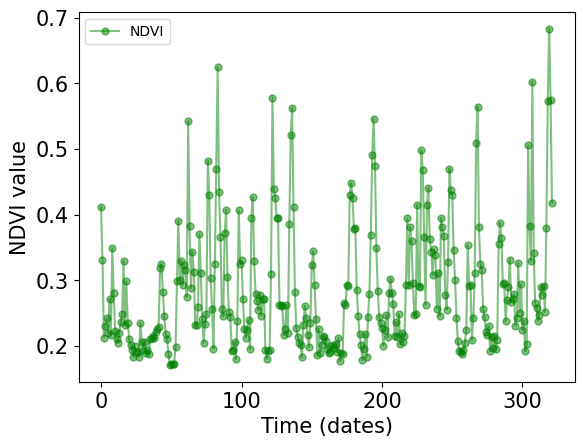

In [14]:
one_pixel = (1500, 1500)
one_lat, one_lon = one_pixel

one_NDVI = NDVI_total[one_lat, one_lon, :]

plt.plot(one_NDVI, marker='o', markersize=5, alpha=0.5, label='NDVI', color='green')
plt.xlabel('Time (dates)')
plt.ylabel('NDVI value')
plt.legend()
plt.show()

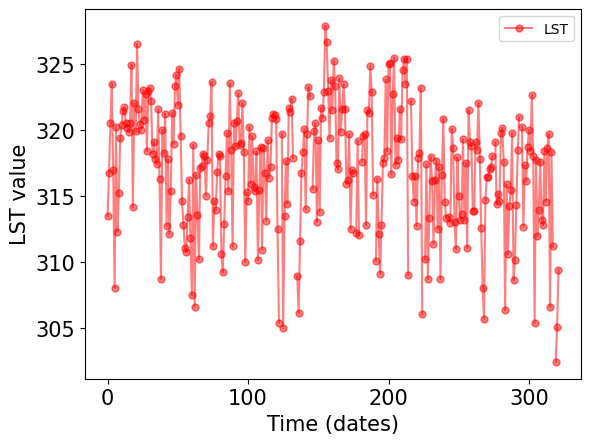

In [15]:
one_LST = LST_total[one_lat, one_lon, :]

plt.plot(one_LST, marker='o', markersize=5, alpha=0.5, label='LST', color='red')
plt.xlabel('Time (dates)')
plt.ylabel('LST value')
#plt.ylim([250, 350])
plt.legend()
plt.show()

In [16]:
import pymannkendall as mk
 
gfg_data = [54, 52, 53, 59, 56, 57, 51, 52, 50, 53]
 
# perform Mann-Kendall Trend Test
mk.original_test(gfg_data)

Mann_Kendall_Test(trend='no trend', h=False, p=0.3672323880406272, z=-0.9016696346674322, Tau=-0.24444444444444444, s=-11.0, var_s=123.0, slope=-0.2857142857142857, intercept=54.285714285714285)

In [17]:
mk.original_test(one_NDVI)

Mann_Kendall_Test(trend='increasing', h=True, p=0.0001718952802312046, z=3.757097872108419, Tau=0.14036106112497823, s=7254.0, var_s=3726750.6666666665, slope=0.00015270266983960127, intercept=0.23124122196758115)

In [18]:
mk.original_test(one_LST)

Mann_Kendall_Test(trend='decreasing', h=True, p=0.00035124501178218637, z=-3.5742412152407796, Tau=-0.13634262177951498, s=-6488.0, var_s=3293973.3333333335, slope=-0.00996564105955225, intercept=319.32457128740924)

## 6. Calculate VCI and TCI for one point pixel

In [19]:
one_VCI = ( one_NDVI - np.nanmax(one_NDVI) ) / ( np.nanmax(one_NDVI) - np.nanmin(one_NDVI) )
one_TCI = ( np.nanmax(one_LST) - one_LST ) / ( np.nanmax(one_LST) - np.nanmin(one_LST) )

In [20]:
alpha = 0.5

one_VHI = alpha*one_VCI + (1-alpha)*one_TCI

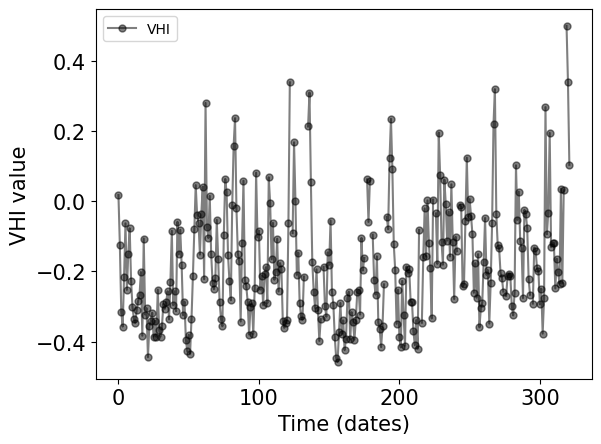

In [21]:
plt.plot(one_VHI, marker='o', markersize=5, alpha=0.5, label='VHI', color='black')
plt.xlabel('Time (dates)')
plt.ylabel('VHI value')
plt.legend()
plt.show()

In [22]:
import seaborn as sns
date_index_array = list(range(len(one_VHI)))
sns.regplot(x=date_index_array, y=one_VHI, color='black')

<Axes: >

In [23]:
mk.original_test(one_VHI)

Mann_Kendall_Test(trend='increasing', h=True, p=0.00010805565312010934, z=3.8717524763594966, Tau=0.1476904972050603, s=7028.0, var_s=3294008.6666666665, slope=0.0003547083578935563, intercept=-0.2656564987007921)